# Creating Factor Graphs with Seed and Running Simulations

This notebook demonstrates how to create factor graphs on the spot with a specified seed and run simulations with them.


In [ ]:
import pickle
import random
import numpy as np
random.seed(42)
np.random.seed(42)
import cProfile
import pstats
import matplotlib.pyplot as plt
# Import necessary modules for factor graph creation and simulation
from bp_base.factor_graph import FactorGraph
from bp_base.engine_base import BPEngine
from policies.convergance import ConvergenceConfig
from bp_base.engines_realizations import (
    DampingEngine,
    DampingSCFGEngine,
    SplitEngine,
    DampingCROnceEngine,
    CostReductionOnceEngine
)
from utils.create.create_factor_graphs_from_config import build_cycle_graph
from utils.path_utils import find_project_root
from configs.global_config_mapping import CT_FACTORIES
# Set the project root
PROJECT_ROOT = find_project_root()

## Create Factor Graphs Directly

Instead of loading factor graphs from pickle files, we'll create them directly with our specified seed.


In [ ]:
variables,factors,edges = build_cycle_graph(
    num_vars=5,
    domain_size=3,
    ct_factory=CT_FACTORIES["random_int"],
    ct_params={"low": 1, "high": 100},
)

graph = FactorGraph(variable_li=variables, factor_li=factors, edges=edges)

In [ ]:
max_iter = 2000
# Run simulations
results = {}

# lb = get_bound(graph)
# print(lb)

# import cProfile
# import pstats
default_engine = BPEngine(
    factor_graph=pickle.loads(pickle.dumps(graph)),
    convergence_config=ConvergenceConfig(),
    use_bct_history=True
)
split_engine_symmetric = SplitEngine(
    factor_graph=pickle.loads(pickle.dumps(graph)),
    convergence_config=ConvergenceConfig(),
    monitor_performance=False,
    split_factor=0.5,
)
split_engine_asymmetric = SplitEngine(
    factor_graph=pickle.loads(pickle.dumps(graph)),
    convergence_config=ConvergenceConfig(),
    monitor_performance=False,
    split_factor=0.6,
)
damping_splitting_engine_symmetric = DampingSCFGEngine(
    factor_graph=pickle.loads(pickle.dumps(graph)),
    convergence_config=ConvergenceConfig(),
    monitor_performance=False,
    split_factor=0.5,
    damping_factor=0.9,
)
damping_splitting_engine_asymmetric = DampingSCFGEngine(
    factor_graph=pickle.loads(pickle.dumps(graph)),
    convergence_config=ConvergenceConfig(),
    monitor_performance=False,
    damping_factor=0.9,
    split_factor=0.6,
)
CR_Damping_engine = DampingCROnceEngine(
    factor_graph=pickle.loads(pickle.dumps(graph)),
    convergence_config=ConvergenceConfig(),
    monitor_performance=False,
    damping_factor=0.9,
    reduction_factor=0.5,
)
CR_engine=CostReductionOnceEngine(
    factor_graph=pickle.loads(pickle.dumps(graph)),
    convergence_config=ConvergenceConfig(),
    monitor_performance=False,
    reduction_factor=0.5,
    anytime=True)
damping_engine= DampingEngine(
    factor_graph=pickle.loads(pickle.dumps(graph)),
    convergence_config=ConvergenceConfig(),
    monitor_performance=False,
    damping_factor=0.9,
)

## Run Simulations with Different Engines

Now we'll run simulations with the created factor graphs using different engines, including the DampingEngine to demonstrate that damping works correctly after each step.


In [ ]:
engines = [default_engine, damping_splitting_engine_symmetric,damping_engine]
results = []
engines[2].run(max_iter=max_iter)
profiler = cProfile.Profile()
profiler.enable()

results.append(engines[2].history.costs)
profiler.disable()
stats = pstats.Stats(profiler)
stats.sort_stats("time")
stats.print_stats(20)
print(f"finished one cycle of fg")


## Plot the Results

Let's plot the costs over iterations for each engine to visualize the convergence behavior.


In [ ]:
plt.figure(figsize=(12, 8))


plt.plot(np.average(results, axis=0), label=engines[2].name)
plt.plot(label="Lower Bound", linestyle="--")
plt.title("Costs over Iterations for Random Factor Graph (Density 0.25)")
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.legend()
plt.grid(True)
plt.show()

## Conclusion

This notebook demonstrates how to create factor graphs on the spot with a specified seed and run simulations with them. We've also verified that the damping functionality works correctly after each step.

Key points:
1. Setting a random seed ensures reproducibility of the factor graphs and simulation results.
2. The fixed damping implementation correctly applies damping after each variable computation step.
3. Different engines show different convergence behaviors on the same factor graph.

BCTCreator initialized:
  - BCT mode: False
  - Variables tracked: 5
  - Message flows: 0
  - Total steps: 19

=== BCT Analysis Summary ===
History mode: Legacy (cycle-based)
Damping factor: 0.0
Variables: 5
Message flows: 0

Per-variable analysis:
  x1:
    Iterations: 19
    Final belief: 0.0000
    Total change: 0.0000
    Converged: True
  x5:
    Iterations: 19
    Final belief: 14.0000
    Total change: 19.0000
    Converged: True
  x4:
    Iterations: 19
    Final belief: 0.0000
    Total change: 0.0000
    Converged: True
  x3:
    Iterations: 19
    Final belief: 19.0000
    Total change: 0.0000
    Converged: True
  x2:
    Iterations: 19
    Final belief: 19.0000
    Total change: 1.0000
    Converged: True

Global costs:
  Initial: 343.00
  Final: 227.00
  Improvement: 116.00


C:\Users\ormul\PycharmProjects\Belief-Propagation-Simulator\tools\bct.py:264: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


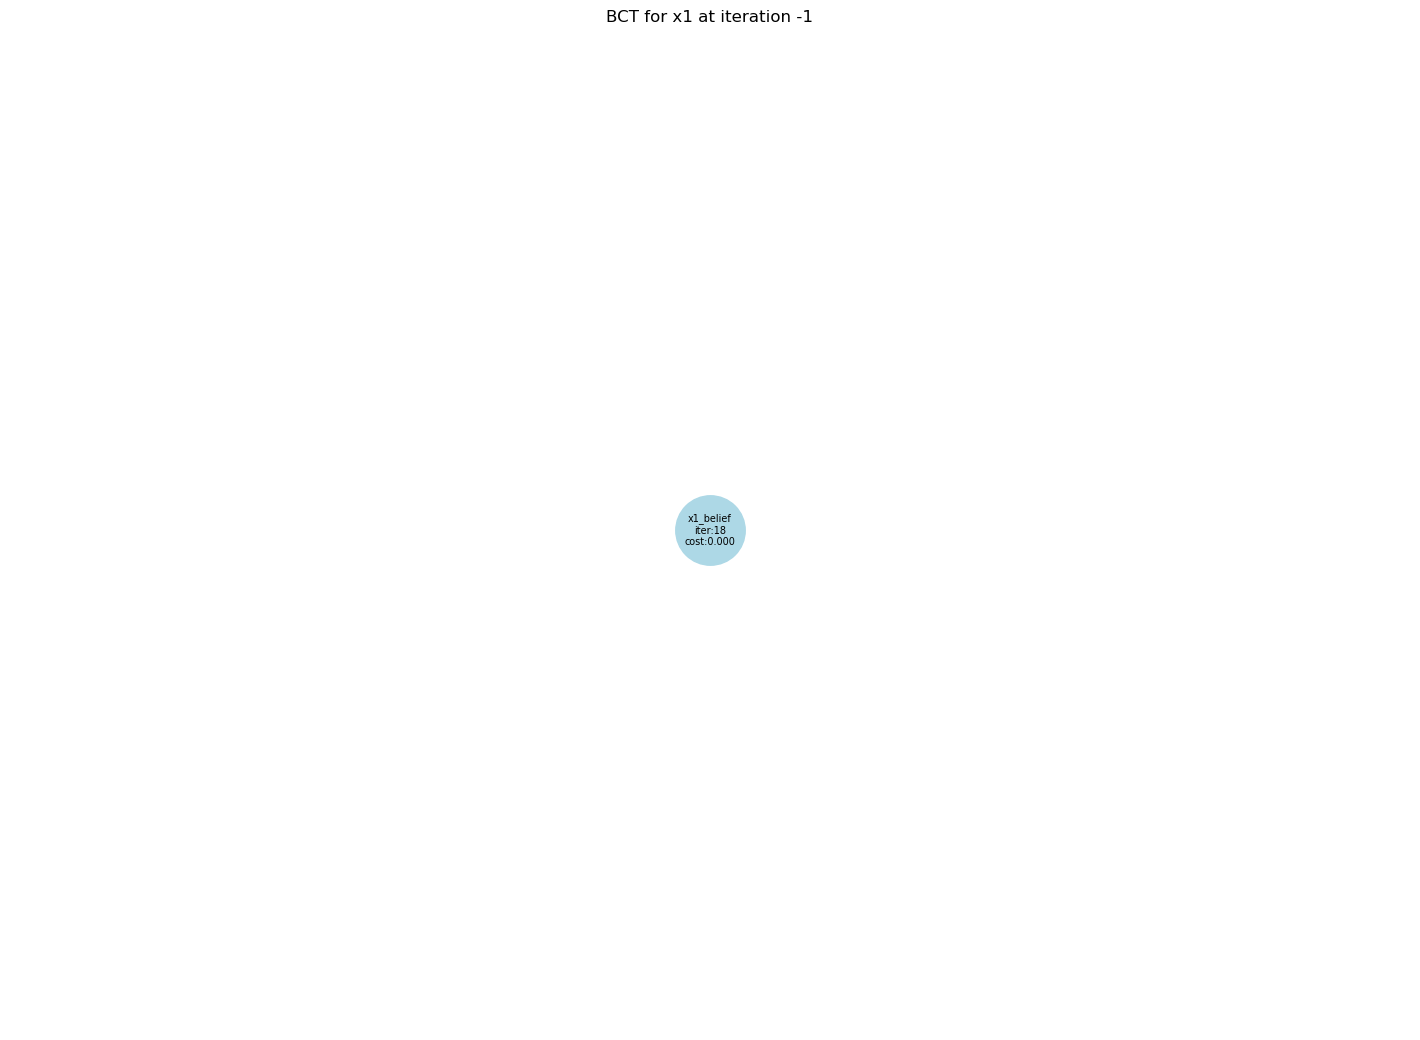

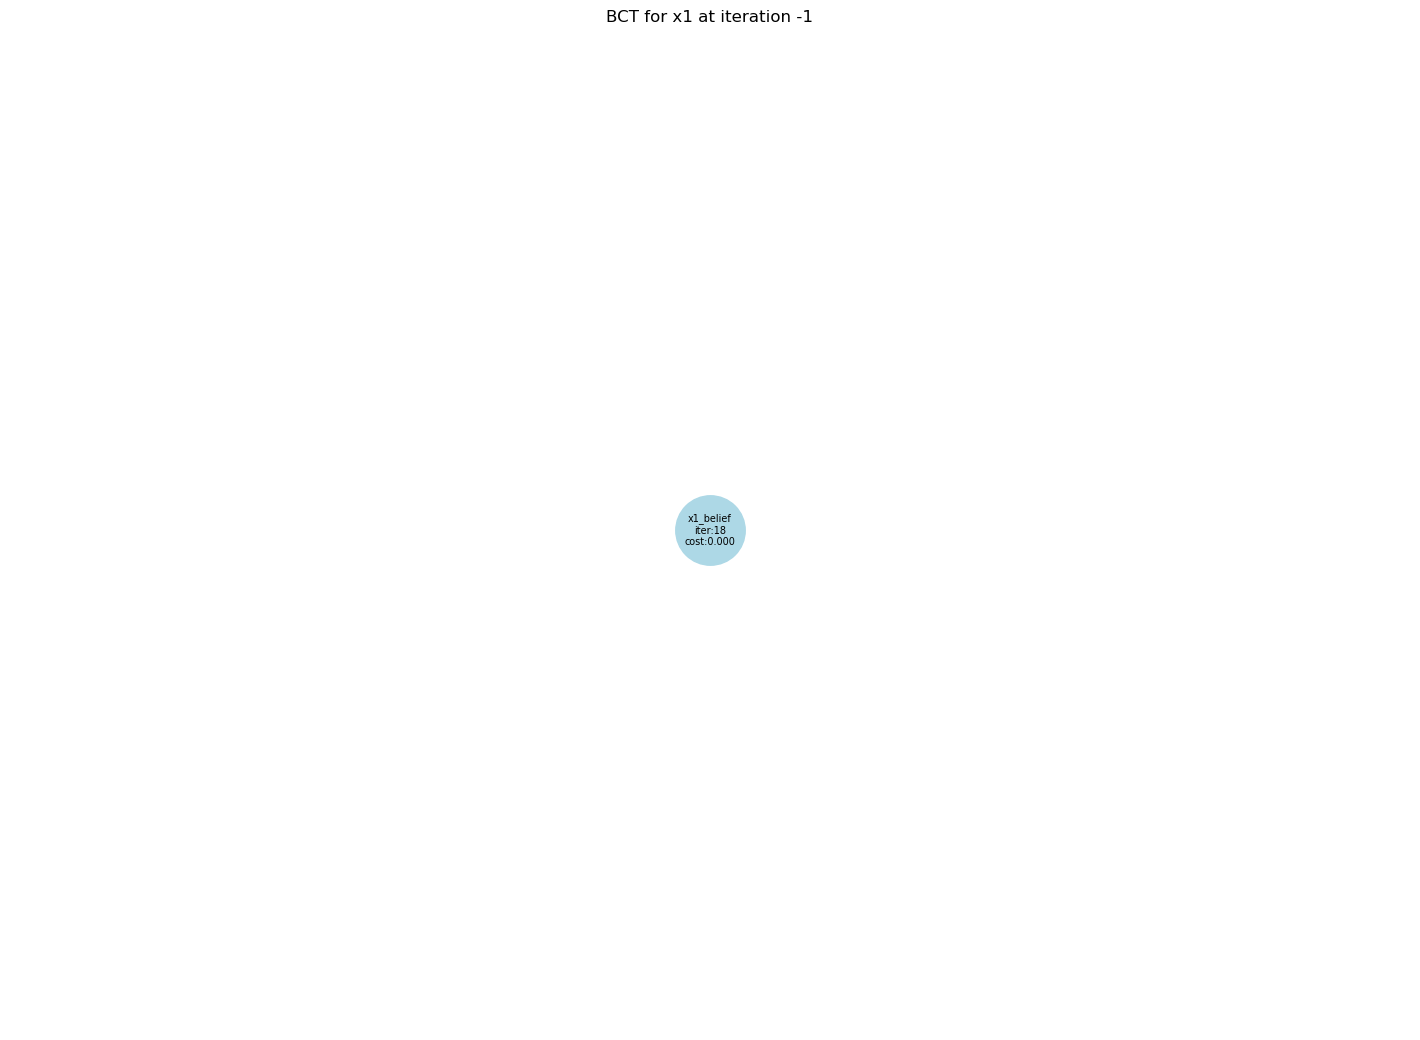

In [10]:
from utils.tools.bct import  BCTCreator
creator = BCTCreator(graph, engines[2].history)
creator.print_summary()
creator.visualize_bct('x1')


